In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cuda


In [8]:
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]

        image = transforms.ToPILImage()(image)

        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            return image, label


In [12]:
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [14]:
train_dataset = CustomMNISTDataset(csv_file='/kaggle/input/digit-recognizer/train.csv', transform=transform, is_test = False)
test_dataset = CustomMNISTDataset(csv_file='/kaggle/input/digit-recognizer/test.csv', transform=transform, is_test = True)

In [17]:
len(train_dataset)

42000

In [18]:
len(test_dataset)

28000

In [22]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle = True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle = False, num_workers=2)

torch.Size([64, 1, 28, 28])


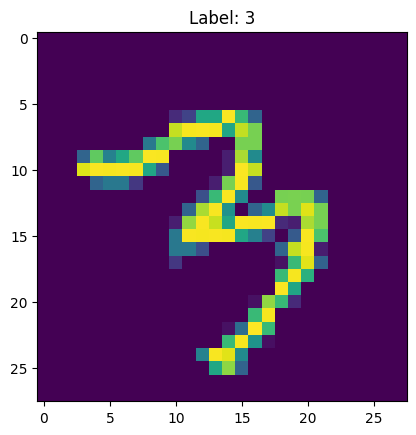

In [30]:
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print(example_data.size())

    example_image_numpy = example_image.permute(1,2,0).numpy()
    plt.imshow(example_image_numpy)
    plt.title(f"Label: {example_labels[0]}")
    plt.show()
    break


In [41]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=32, kernel_size = 3, stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size = 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128*7*7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128,20)
        self.fc3= nn.Linear(20,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        

        x_size = x.size(1)*x.size(2)*x.size(3)

        x = x.view(-1, x_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
       

In [42]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.001, momentum = 0.9)

In [44]:
num_epochs = 100
running_loss = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0
    

[1, 100] Loss: 0.009
[1, 200] Loss: 0.010
[1, 300] Loss: 0.008
[1, 400] Loss: 0.010
[1, 500] Loss: 0.007
[1, 600] Loss: 0.006
[2, 100] Loss: 0.012
[2, 200] Loss: 0.008
[2, 300] Loss: 0.008
[2, 400] Loss: 0.011
[2, 500] Loss: 0.008
[2, 600] Loss: 0.007
[3, 100] Loss: 0.009
[3, 200] Loss: 0.005
[3, 300] Loss: 0.006
[3, 400] Loss: 0.007
[3, 500] Loss: 0.006
[3, 600] Loss: 0.008
[4, 100] Loss: 0.010
[4, 200] Loss: 0.005
[4, 300] Loss: 0.006
[4, 400] Loss: 0.006
[4, 500] Loss: 0.009
[4, 600] Loss: 0.008
[5, 100] Loss: 0.012
[5, 200] Loss: 0.005
[5, 300] Loss: 0.005
[5, 400] Loss: 0.007
[5, 500] Loss: 0.006
[5, 600] Loss: 0.007
[6, 100] Loss: 0.011
[6, 200] Loss: 0.005
[6, 300] Loss: 0.006
[6, 400] Loss: 0.008
[6, 500] Loss: 0.006
[6, 600] Loss: 0.008
[7, 100] Loss: 0.008
[7, 200] Loss: 0.006
[7, 300] Loss: 0.006
[7, 400] Loss: 0.005
[7, 500] Loss: 0.007
[7, 600] Loss: 0.008
[8, 100] Loss: 0.009
[8, 200] Loss: 0.006
[8, 300] Loss: 0.006
[8, 400] Loss: 0.005
[8, 500] Loss: 0.006
[8, 600] Loss

In [51]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().tolist())
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions)+1),
    "Label": predictions
})

submission.to_csv('predictions_final.csv', index=False)